In [1]:
!pip install pandas numpy matplotlib seaborn nltk scikit-learn transformers
!pip install unidecode
!pip install textblob
!pip install --upgrade pip
!pip install --upgrade torch transformers
!pip install transformers
# Install torch with CUDA 11.8 compatible build (works for Colab GPU)
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install sentence-transformers

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Phase 1: Data Loading & Cleaning

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_path = '/content/songs_with_attributes_and_lyrics.csv'

df = pd.read_csv(file_path, engine='python', on_bad_lines='skip')
print(df.shape)
df.head()

KeyboardInterrupt: 

# Phase 2: Exploratory Data Analysis (EDA)

In [ ]:
# Basic Info
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)

# Data Types and Nulls
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Shape: (694393, 17)

Columns:
 Index(['id', 'name', 'album_name', 'artists', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'lyrics'],
      dtype='object')

Data Types:
 id                   object
name                 object
album_name           object
artists              object
danceability        float64
energy              float64
key                  object
loudness            float64
mode                 object
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms         float64
lyrics               object
dtype: object

Missing Values:
 id                       0
name                   577
album_name          412792
artists                695
danceability           695
energy                 695
key                    695
loudness      

In [ ]:
# Drop rows with missing lyrics as they are critical for NLP
df = df.dropna(subset=['lyrics'])
print("Shape after dropping missing lyrics:", df.shape)

Shape after dropping missing lyrics: (693671, 17)


In [ ]:
# Summary of numerical columns
print(df.describe())

        danceability         energy       loudness    speechiness  \
count  496998.000000  496998.000000  496998.000000  496998.000000   
mean        0.552204       0.653465      -7.839657       0.084603   
std         0.170289       0.238798       3.801606       0.093797   
min         0.000000       0.000000     -60.000000       0.000000   
25%         0.437000       0.485000      -9.757000       0.034700   
50%         0.559000       0.689000      -7.038000       0.048300   
75%         0.677000       0.858000      -5.148000       0.089000   
max         0.992000       1.000000       4.882000       0.966000   

        acousticness  instrumentalness       liveness        valence  \
count  496998.000000     496998.000000  496998.000000  496998.000000   
mean        0.280727          0.082483       0.220016       0.491205   
std         0.311581          0.213539       0.196102       0.252060   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.0117

**Summary**

* Danceability: avg 0.55 (moderate), range 0–0.98
* Energy: avg 0.66 (high), range 0–1
* Loudness: median -7 dB
* Speechiness: median 0.05 (mostly musical)
* Acousticness: median 0.14 (few acoustic tracks)
* Instrumentalness: very low (most tracks have vocals)
* Valence: avg 0.48 (neutral mood)
* Tempo: median 120 BPM (standard pop tempo)
* Duration: avg ~3.9 mins; max ~79 mins (some outliers)
* Missing: ‘album_name’ (58k), ‘lyrics’ (dropped 5 rows)

## Data Visualizations

### 1. Loudness vs Energy

[Text(0.5, 1.0, 'Loudness vs Energy')]

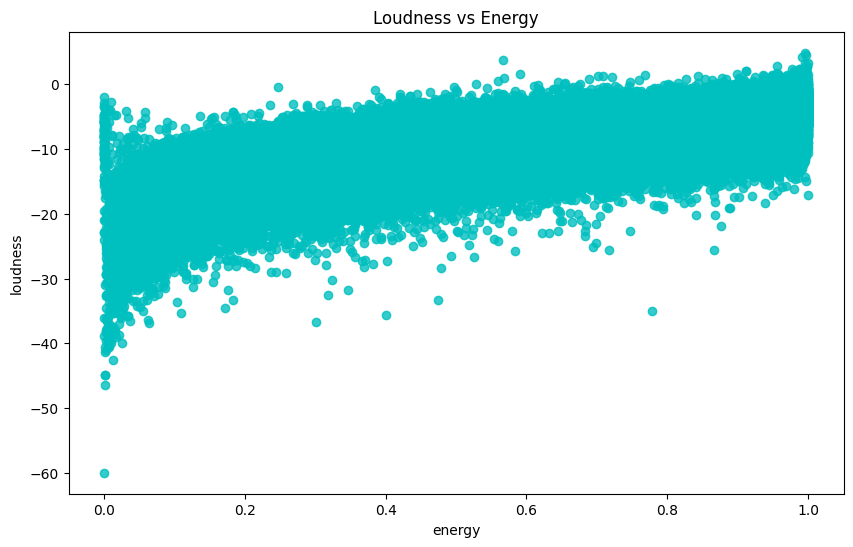

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(data = df, y= "loudness", x = "energy", color = "c").set(title="Loudness vs Energy")

 Insight - Positive correlation between a track’s energy and its loudness, so higher energy songs tend to be louder.

### 2. Correlation Heatmap
It shows which song attributes move together, to build smarter queries and avoid redundant features in RAG or recommendation models

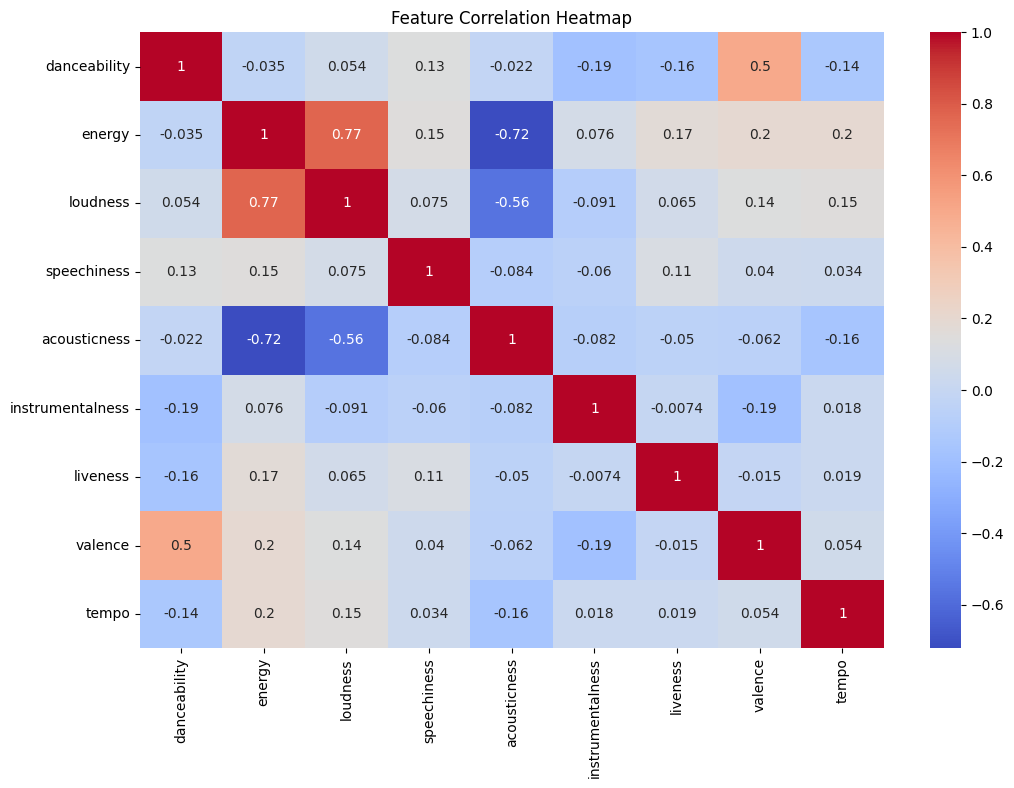

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df[['danceability','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

Insights
* Energy and loudness are highly positively correlated (0.77)
* Energy and acousticness are highly negatively correlated (-0.72)

Helps end goal by:
* Designing better retrieval queries (e.g. energetic & acoustic are opposites).
* Feature selection for recommendations or RAG embeddings.

### 3. Danceability vs Valence Scatter Plot

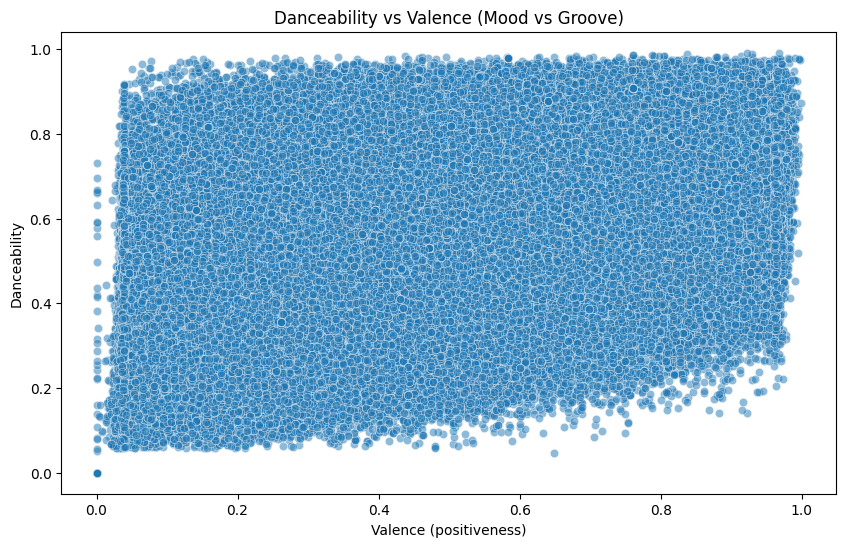

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='valence', y='danceability', alpha=0.5)
plt.title('Danceability vs Valence (Mood vs Groove)')
plt.xlabel('Valence (positiveness)')
plt.ylabel('Danceability')
plt.show()

Insight - Danceability increases slightly with valence, so happier songs is more danceable.

### 4. Top Artists Bar Plot

/tmp/ipython-input-10-1388537596.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')


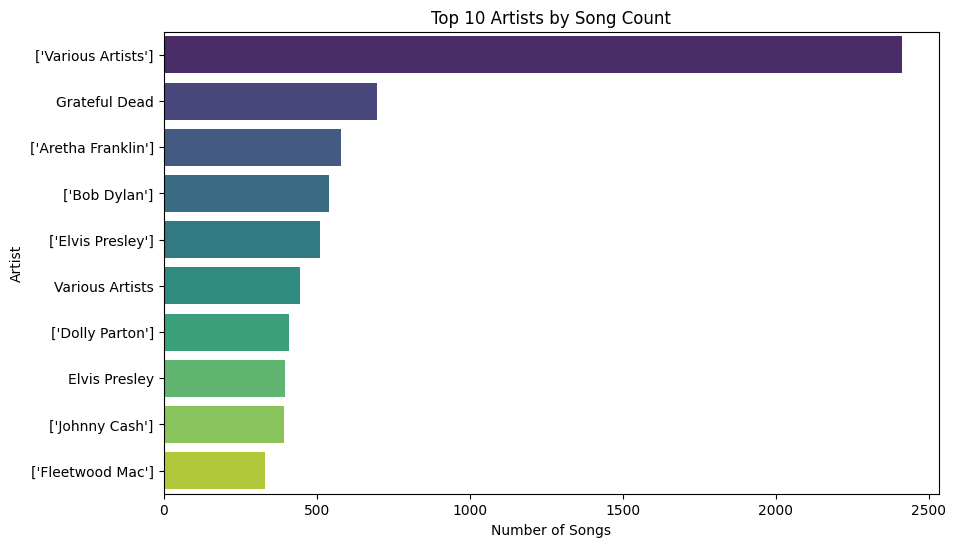

In [ ]:
plt.figure(figsize=(10,6))
top_artists = df['artists'].value_counts().head(10)
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title('Top 10 Artists by Song Count')
plt.xlabel('Number of Songs')
plt.ylabel('Artist')
plt.show()

### 5. Distribution of Valence

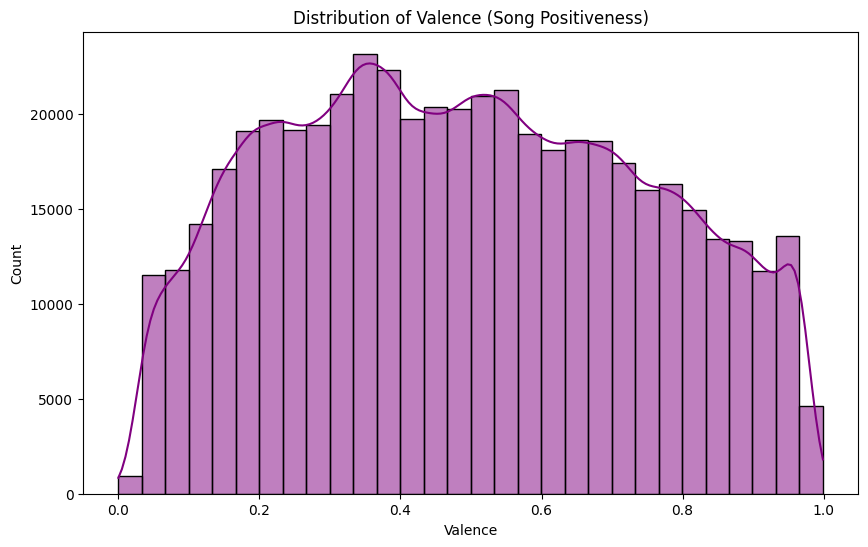

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['valence'], bins=30, kde=True, color='purple')
plt.title('Distribution of Valence (Song Positiveness)')
plt.xlabel('Valence')
plt.ylabel('Count')
plt.show()

Insight - Valence distribution is almost uniform - diverse emotional content in songs.

## Word Cloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Join all lyrics into one string
text = " ".join(lyrics for lyrics in df['lyrics'].astype(str))

# Create word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=200, width=800, height=400).generate(text)

# Plot
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Lyrics')
plt.show()

Insight - This word cloud shows the most frequent words in song lyrics with common word like love, knowing, wanting and time.

Some encoding symbols (e.g. 'à', '¾') are present, so I need to do text cleaning before NLP or RAG-based modeling to ensure clean, meaningful embeddings.

# Phase 3: Data Cleaning for Lyrics

In [ ]:
import re
import unidecode

def clean_lyrics(text):
    text = unidecode.unidecode(text)  # normalize accents
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

# Apply to dataset
df['clean_lyrics'] = df['lyrics'].apply(clean_lyrics)

# Preview cleaned lyrics
df[['lyrics', 'clean_lyrics']].head()

,lyrics,clean_lyrics
0,"He said he came from Jamaica,\n he owned a cou...",he said he came from jamaica he owned a couple...
1,"Fucked a bitch, now she running with my kids\n...",fucked a bitch now she running with my kids an...
2,"Oh, my God, I'm going crazy\n",oh my god im going crazy
3,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...
4,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...


In [ ]:
# Save as CSV for easy reload later
df.to_csv('spotify_cleaned_with_textblob.csv', index=False)

# Phase 4: Sentiment Analysis

Goal: Sentiment insights for mood-based retrieval or recommendations

## 4.1 Using TextBlob

* Fast lexicon-based sentiment analysis
* Generates polarity scores between -1 (negative) to +1 (positive)

In [ ]:
import pandas as pd

# Load saved dataset instead of re-running cleaning + textblob
df = pd.read_csv('spotify_cleaned_with_textblob.csv')

print(df.shape)
df.head()

(307633, 18)


,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics,clean_lyrics
0,0Prct5TDjAnEgIqbxcldY9,!,UNDEN!ABLE,['HELLYEAH'],0.415,0.6050,7,-11.157,1,0.0575,0.00116,0.838000,0.4710,0.193,100.059,79500.0,"He said he came from Jamaica,\n he owned a cou...",he said he came from jamaica he owned a couple...
1,2ASl4wirkeYm3OWZxXKYuq,!!,NaN,Yxngxr1,0.788,0.6480,7,-9.135,0,0.3150,0.90000,0.000000,0.1760,0.287,79.998,114000.0,"Fucked a bitch, now she running with my kids\n...",fucked a bitch now she running with my kids an...
2,69lcggVPmOr9cvPx9kLiiN,!!! - Interlude,Where I Belong EP,['Glowie'],0.000,0.0354,7,-20.151,0,0.0000,0.90800,0.000000,0.4790,0.000,0.000,11413.0,"Oh, my God, I'm going crazy\n",oh my god im going crazy
3,4U7dlZjg1s9pjdppqZy0fm,!!De Repente!!,Un Palo Al Agua (20 Grandes Canciones),['Rosendo'],0.657,0.8820,5,-6.340,1,0.0385,0.00740,0.000013,0.0474,0.939,123.588,198173.0,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...
4,4v1IBp3Y3rpkWmWzIlkYju,!!De Repente!!,Fuera De Lugar,['Rosendo'],0.659,0.8930,5,-8.531,1,0.0411,0.09220,0.000019,0.0534,0.951,123.600,199827.0,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...


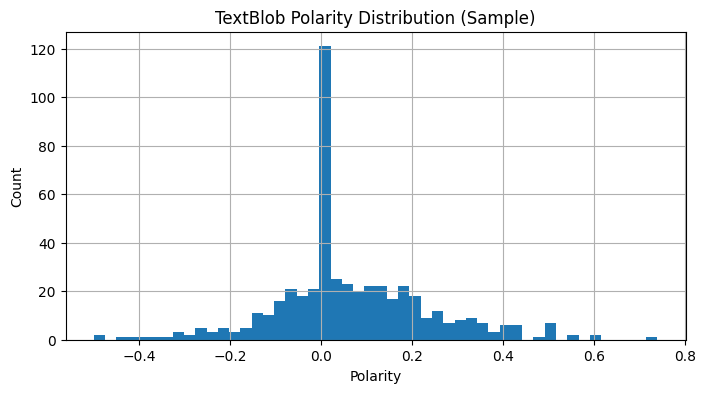

In [ ]:
sample_df = df.sample(500, random_state=42).copy()

from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

sample_df['sentiment_polarity'] = sample_df['clean_lyrics'].apply(get_sentiment)

# Quick plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sample_df['sentiment_polarity'].hist(bins=50)
plt.title('TextBlob Polarity Distribution (Sample)')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show()

Insight - Most lyrics have polarity near zero, so a neutral sentiment with a slight skew towards positive emotions.

## 4.2 Using Hugging Face Transformer (Sample)

In [ ]:
from transformers import pipeline

# Initialize sentiment pipeline (default: distilbert sentiment classifier)
sentiment_pipeline = pipeline("sentiment-analysis")

# Test on a single sample first (ALWAYS test before batch processing)
print(sentiment_pipeline("I love this song so much"))

# Apply on a smaller sample to avoid RAM crash
sample_df = df.sample(100, random_state=42).copy()  # sample 100 rows for demo

# Apply transformer sentiment analysis safely (limit input to 512 tokens)
sample_df['transformer_sentiment'] = sample_df['clean_lyrics'].apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])

# View results
sample_df[['clean_lyrics', 'transformer_sentiment']].head()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[{'label': 'POSITIVE', 'score': 0.9998782873153687}]


,clean_lyrics,transformer_sentiment
368149,early in the morning by the break of day thats...,POSITIVE
673127,oh i wish i was lucky but i know that im not c...,NEGATIVE
500150,have mercy been waitin for the bus all day hav...,POSITIVE
405212,ho ho ho chorus tonto jump on it jump on it ju...,POSITIVE
238578,dndu dddu dndu d dd ddegn aeur n doneurddegnz ...,NEGATIVE


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('clean_lyrics').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('transformer_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['transformer_sentiment'].value_counts()
    for x_label, grp in _df_2.groupby('clean_lyrics')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('clean_lyrics')
_ = plt.ylabel('transformer_sentiment')

from matplotlib import pyplot as plt
_df_3['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('clean_lyrics').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('transformer_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['transformer_sentiment'].value_counts()
    for x_label, grp in _df_7.groupby('clean_lyrics')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('clean_lyrics')
_ = plt.ylabel('transformer_sentiment')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['clean_lyrics'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='clean_lyrics', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['transformer_sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='index', y='transformer_sentiment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
import re

# Function to detect gibberish or overly short/meaningless lyrics
def is_gibberish(text):
    # Remove spaces and check if >70% is non-alphabetic or too short
    cleaned = re.sub(r'\s+', '', text)
    non_alpha_ratio = sum(1 for c in cleaned if not c.isalpha()) / len(cleaned) if len(cleaned) > 0 else 1
    return (non_alpha_ratio > 0.5) or (len(cleaned) < 10)

# Apply and filter
df = df[~df['clean_lyrics'].apply(is_gibberish)]

print(df.shape)

(307613, 18)


In [ ]:
df.to_csv('spotify_cleaned_with_sentiment.csv', index=False)

# Phase 5

In [10]:
import pandas as pd
df = pd.read_csv('spotify_cleaned_with_sentiment.csv')
df.head()

,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics,clean_lyrics
0,0Prct5TDjAnEgIqbxcldY9,!,UNDEN!ABLE,['HELLYEAH'],0.415,0.6050,7,-11.157,1,0.0575,0.00116,0.838000,0.4710,0.193,100.059,79500.0,"He said he came from Jamaica,\n he owned a cou...",he said he came from jamaica he owned a couple...
1,2ASl4wirkeYm3OWZxXKYuq,!!,NaN,Yxngxr1,0.788,0.6480,7,-9.135,0,0.3150,0.90000,0.000000,0.1760,0.287,79.998,114000.0,"Fucked a bitch, now she running with my kids\n...",fucked a bitch now she running with my kids an...
2,69lcggVPmOr9cvPx9kLiiN,!!! - Interlude,Where I Belong EP,['Glowie'],0.000,0.0354,7,-20.151,0,0.0000,0.90800,0.000000,0.4790,0.000,0.000,11413.0,"Oh, my God, I'm going crazy\n",oh my god im going crazy
3,4U7dlZjg1s9pjdppqZy0fm,!!De Repente!!,Un Palo Al Agua (20 Grandes Canciones),['Rosendo'],0.657,0.8820,5,-6.340,1,0.0385,0.00740,0.000013,0.0474,0.939,123.588,198173.0,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...
4,4v1IBp3Y3rpkWmWzIlkYju,!!De Repente!!,Fuera De Lugar,['Rosendo'],0.659,0.8930,5,-8.531,1,0.0411,0.09220,0.000019,0.0534,0.951,123.600,199827.0,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...


## Import and Load Model

In [8]:
from sentence_transformers import SentenceTransformer

# Load a lightweight powerful model
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Generate Embeddings

In [6]:
import torch

In [9]:
# Sample 3000 rows from your cleaned dataframe
df_sample = df.sample(n=3000, random_state=42).reset_index(drop=True)

print(df_sample.shape)
df_sample.head()

NameError: name 'df' is not defined

In [11]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Convert lyrics to list
lyrics_list = df_sample['clean_lyrics'].tolist()

# Encode in batches efficiently
embeddings = model.encode(lyrics_list, batch_size=32, show_progress_bar=True, device=device)

# Convert to numpy array
embeddings = np.array(embeddings)

print("Embeddings shape:", embeddings.shape)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings shape: (3000, 384)


In [12]:
# Attach embeddings to your sample dataframe
df_sample['embedding'] = embeddings.tolist()

# Save for Phase 6 RAG retrieval
df_sample.to_csv('spotify_sample_with_embeddings.csv', index=False)
np.save('lyrics_sample_embeddings.npy', embeddings)

# Phase 6: Retrieval & QA Pipeline

6.1 Load embeddings and data

In [13]:
import pandas as pd
import numpy as np

# Load
df_sample = pd.read_csv('spotify_sample_with_embeddings.csv')
embeddings = np.load('lyrics_sample_embeddings.npy')

print(df_sample.shape, embeddings.shape)

(3000, 19) (3000, 384)


6.2 Define retrieval function using cosine similarity

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve(query, model, df, embeddings, top_k=5):
    # Encode query
    query_emb = model.encode([query])

    # Calculate cosine similarity
    sims = cosine_similarity(query_emb, embeddings)[0]

    # Get top_k indices
    top_k_idx = sims.argsort()[-top_k:][::-1]

    # Return results
    return df.iloc[top_k_idx][['name', 'artists', 'clean_lyrics']]

6.3 Test retrieval

In [15]:
# Query
results = retrieve("I want a sad song", model, df_sample, embeddings, top_k=3)

print(results)

                                                   name  \
1166                                             Asleep   
2038                                       Another Song   
1163  Don't Let the Teardrops Rust Your Shining Hear...   

                          artists  \
1166                  ['Xiu Xiu']   
2038               ['Carpenters']   
1163  ['Everything But The Girl']   

                                           clean_lyrics  
1166  sing me to sleep sing me to sleep im tired and...  
2038  the moon that rose now descended and the love ...  
1163  sorrow is a lonely road where the rain like yo...  


In [16]:
# Temporarily show all columns and wider width
import pandas as pd

pd.set_option('display.max_colwidth', None)  # show full text in cells
pd.set_option('display.max_rows', None)      # show all rows

# Display results again
print(results)

                                                                 name  \
1166                                                           Asleep   
2038                                                     Another Song   
1163  Don't Let the Teardrops Rust Your Shining Heart - 2012 Remaster   

                          artists  \
1166                  ['Xiu Xiu']   
2038               ['Carpenters']   
1163  ['Everything But The Girl']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              